<a href="https://colab.research.google.com/github/cbun1123/map_fit/blob/main/Stage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!rm -r /content/map_fit
!git clone https://github.com/cbun1123/map_fit

!unzip /content/map_fit/8bit/X_train_1.zip -d /content/map_fit/X_train
!unzip /content/map_fit/8bit/X_train_2.zip -d /content/map_fit/X_train

!unzip /content/map_fit/8bit/X_test_1.zip -d /content/map_fit/X_test

!rm /content/map_fit/*.zip

In [2]:
%%capture
#!pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/cuda/112/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl --force-reinstall
#!pip install git+https://github.com/PytorchLightning/pytorch-lightning.git@master --upgrade
!pip install pytorch-lightning
!pip install tensorboardcolab
!pip install torchmetrics
%env PYTHONPATH=.:$PYTHONPATH

In [59]:
!nvidia-smi
n = 1

Tue Aug 23 10:32:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    32W /  70W |   1344MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [60]:
import numpy as np
import cv2
import glob
import math
import time
import os
import gc
import natsort

import matplotlib.pyplot as plt

from google.colab import files
from google.colab.patches import cv2_imshow
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.onnx
from torch.utils.data import Dataset,DataLoader
from torch.utils.tensorboard import SummaryWriter

import pytorch_lightning as pl

import torchmetrics
from torchmetrics.functional import *

import torchvision
from torchvision import transforms

#import torch_xla
#import torch_xla.core.xla_model as xm

In [ ]:
%load_ext tensorboard
%tensorboard --logdir='/content/lightning_logs'

In [62]:
## Training data
# Load training images
filenames = glob.glob("/content/map_fit/X_train/*.jpg")
filenames = natsort.natsorted(filenames)
X_train = [cv2.imread(img,-1) for img in filenames] # cv2.imread(img)

# Load training labels
y_train = np.load('/content/map_fit/8bit/Y_train.npy')
Z_train = np.load('/content/map_fit/8bit/Z_train.npy')


## Testing data
# Load testing images
filenames = glob.glob("/content/map_fit/X_test/*.jpg")
filenames = natsort.natsorted(filenames)
X_test = [cv2.imread(img,-1) for img in filenames]

# Load training labels
y_test = np.load('/content/map_fit/8bit/Y_test.npy')
Z_test = np.load('/content/map_fit/8bit/Z_test.npy')


# Print dataset sizes
print(f'Training set : {np.shape(X_train)}')
print(f'Testing set : {np.shape(X_test)}')

Training set : (5000, 224, 224)
Testing set : (1000, 224, 224)


In [63]:
SIZE = 224

# Define circular mask for RGB tensor image
lin = np.linspace(-1,1,SIZE)
[Xm,Ym] = np.meshgrid(lin,lin)
idx = ((Xm**2+Ym**2)<1)
idx = np.stack([idx,idx,idx], axis=0)
idx_t = torch.from_numpy(idx)

# Define custom dataset class inheriting from torch.Dataset
class imageDataset(Dataset):
    def __init__(self,X,y,Z):
        'Initialization'
        # Load data
        self.X = np.array(X).astype(np.float32)
        self.y = np.array(y).astype(np.float32)
        self.Z = np.array(Z).astype(np.float32)

        # Define dataset size
        self.n_samples = self.X.shape[0]

        # Define target distribution
        mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
        std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

        # Define corrected distribution for masked image
        fact = torch.div(SIZE**2,idx_t.sum(dim=[1,2])).view(3,1,1)
        corr_mean = torch.mul(fact,mean)
        corr_std = torch.sqrt(torch.mul(fact,torch.pow(std,2)) - torch.mul(torch.mul(fact,fact-1),torch.pow(mean,2)))

        # Define transformations
        lambdaMask = lambda T: torch.mul(T,idx_t)
        lambdaNorm = lambda T: torch.div(T-T.mean(dim=[1,2]).view(3,1,1),T.std(dim=[1,2]).view(3,1,1))
        lambdaScale = lambda T: torch.mul(T,corr_std) + corr_mean

        # Define global transformation
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Lambda(lambdaMask),
            transforms.Lambda(lambdaNorm),
            transforms.Lambda(lambdaScale),
            transforms.Lambda(lambdaMask),
        ])

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.X[index]

        # Rescale sample to original values
        #X = (X/255)*(self.Z[index,1]-self.Z[index,0]) + self.Z[index,0]

        # Apply transforms
        X = self.transform(X)

        # Load and format labels
        y = self.y[index]
        y = torch.from_numpy(y)

        # Package sample
        sample = X,y
        return sample

    def __len__(self):
        'Dataset length'
        return self.n_samples

    def getData(self):
        'Returns all data labels'

        # Load all images
        #X = torch.stack([torch.mul(self.transform(self.X[i]),idx_t) for i in range(len(self.y))])

        # Load all labels
        y = torch.from_numpy(self.y)
        return y

# Initialize datasets
trainset = imageDataset(X_train,y_train,Z_train)
testset = imageDataset(X_test,y_test,Z_test)

# Garbage collection
del X_train
del y_train
del X_test
del y_test
del filenames
del Xm
del Ym
del lin
del idx
gc.collect()

0

Freezing weights:
```
for param in backbone.parameters():
    param.requires_grad = False
self.net = backbone
```

Replacing last layer:
```
backbone.fc = nn.Linear(in_features=backbone.fc.in_features, out_features=2, bias=True)
self.net = backbone
```

Adding new last layer:
```
added_layer = nn.Linear(in_features=backbone.fc.out_features, out_features=2, bias=True)
self.net = nn.Sequential(backbone,nn.ReLU(inplace=True),added_layer)
```

Dropout testing
~~~
def append_dropout(model, rate):
    for name, module in model.named_children():
        if len(list(module.children())) > 0:
            append_dropout(module,rate)
        if isinstance(module, nn.ReLU):
            module.register_forward_hook(lambda m, inp, out: F.dropout(out, p=rate, training=m.training))
            setattr(model, name, new)
~~~

In [71]:
# Define model
model_name = "shufflenet_v2_x1_0" # shufflenet_v2_x1_0

# Define hyperparameters
BATCH_SIZE = 512 # TPU has very little memory, 64 max
num_epochs = 5
val_check_interval = 0.5
learning_rate = 0.000229
betas = [0.9,0.999] # Gradient decay factor, Squared
eps = 1e-8
weight_decay = 1e-3 # L2 Regularization
step_size = 5 # Learn rate drop period
gamma = 0.8 # Learn rate drop factor
rate = 0.0 # Dropout rate, 0 for none
swa_lrs = 1e-3 # Stochastic weight averaging factor

# Define pyTorch-Lightning model class inheriting from LightningModule class
class LitModel(pl.LightningModule):
    def __init__(self):
        'Initialize module'
        # Inherit initialization from LightningModule class
        super().__init__()

        # Initialize a pretrained network
        backbone = torch.hub.load('pytorch/vision:v0.10.0', model_name, pretrained=True)
        #backbone = torchvision.models.shufflenet_v2_x1_0(pretrained=True)

        # Replaces last layer for 2 parameter regression
        backbone.fc = nn.Linear(in_features=backbone.fc.in_features, out_features=2, bias=True)
        self.net = backbone

        # Define internal hyperparameters for possible tuning
        self.batch_size = BATCH_SIZE
        self.lr = learning_rate

    def train_dataloader(self):
        'Internal training dataloader'
        return DataLoader(dataset=trainset, batch_size=self.batch_size)

    def val_dataloader(self):
        'Internal validation dataloader'
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def test_dataloader(self):
        'Internal testing dataloader'
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def predict_dataloader(self):
        'Internal prediction dataloader'
        return DataLoader(dataset=testset, batch_size=self.batch_size)

    def forward(self,x):
        'Forward function'
        return self.net(x)

    def training_step(self, batch, batch_idx):
        'Training loop step'
        # Get data from batch
        input, labels = batch
        # Compute predictions
        output = self.net(input)
        # Compute loss
        loss = F.mse_loss(output,labels) # mean_squared_log_error(output,labels) # F.mse_loss(output,labels)
        # Logging to TensorBoard
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        'Validation loop step'
        # Get data from batch
        input, labels = batch
        # Compute predictions
        output = self.net(input)
        # Compute loss
        loss = F.mse_loss(output,labels)
        # Logging to TensorBoard
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        'Testing loop step'
        # Get data from batch
        input, labels = batch
        # Compute predictions
        output = self.net(input)
        # Compute loss
        loss = torch.std(labels-output, dim=0).mean()
        # Logging to TensorBoard
        self.log("test_loss", loss)
        return loss

    def predict_step(self, batch, batch_idx):
        'Prediction loop step'
        # Get data from batch
        input, labels = batch
        # Compute predictions
        return self.net(input)

    def configure_optimizers(self):
        'Training optimizers definition'
        # Backpropagation optimize
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.lr, betas=betas, eps=eps, weight_decay=weight_decay)
        #optimizer = torch.optim.RMSprop(self.parameters(), lr=self.lr, alpha=0.86, eps=eps, weight_decay=weight_decay, momentum=0.9)*

        # Learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=step_size,gamma=gamma)
        return [optimizer], [lr_scheduler]

In [ ]:
# Garbage collection
torch.cuda.empty_cache()
gc.collect()

# Model initialization, possibly by checkpoint
model = LitModel() #.load_from_checkpoint("/content/checkpoints/last-v11.ckpt")

# Define TensorBoard logger
logger = pl.loggers.TensorBoardLogger(save_dir=os.getcwd(), version=n, name="lightning_logs")
n += 1

# Define training callbacks
checkpoint_callback = pl.callbacks.ModelCheckpoint(dirpath="/content/checkpoints",
                                      save_last=True,
                                      save_top_k=1,
                                      monitor="val_loss",
                                      mode="min",
                                      filename=model_name+"-{epoch:02d}-{val_loss:.5f}"
                                      )
stagnate_callback = pl.callbacks.EarlyStopping(monitor="val_loss",
                                               mode="min",
                                               check_finite=True,
                                               patience=np.ceil(num_epochs/val_check_interval)
                                               )
swa_callback = pl.callbacks.StochasticWeightAveraging(swa_lrs=swa_lrs)

# Defining trainer
trainer = pl.Trainer(accelerator="gpu",             # CPU, GPU or TPU
                     val_check_interval=val_check_interval,
                     auto_lr_find=False,            # True or False   
                     auto_scale_batch_size=None,    # None or "binsearch"
                     deterministic=False,           # True or False
                     fast_dev_run=False,            # True or False or Epoch count
                     logger=logger,                 # logger or False
                     max_epochs=1000,               # -1 for Infinite
                     precision=32,                  # Default 32
                     profiler=None,                 # None, "simple" or "advanced"
                     enable_checkpointing=True,     # True or False
                     callbacks=[checkpoint_callback, stagnate_callback, swa_callback],
                     gradient_clip_val=0.25,
                     log_every_n_steps=1
                     #, detect_anomaly=True #, overfit_batches=1
                     )                  

# Autotune hyperparameters
trainer.tune(model=model)

# Training
trainer.fit(model=model)

In [ ]:
# Garbage collection
torch.cuda.empty_cache()
gc.collect()

# Load best checkpoint and get testing loss
#t_loss = trainer.test()[0].get('test_loss')

# Get test labels
y_test = testset.getData()

# Load best checkpoint and get test predictions
y_pred = torch.vstack(trainer.predict())

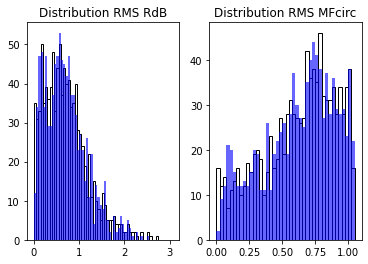

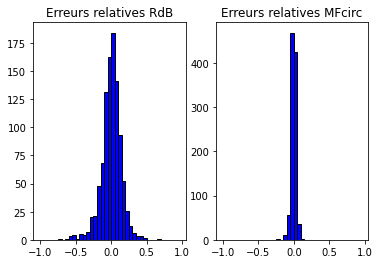

Standard deviation of RdB errors : 0.147
Standard deviation of MFcirc errors : 0.032


In [77]:
# Garbage collection
torch.cuda.empty_cache()
gc.collect()

# Print mean relative errors
#print(torch.abs(torch.div(y_pred-y_test,y_test)).mean().item())
##print(torch.abs(torch.div(y_pred-y_test,y_pred)).mean().item())

# Define RMS histogram binning
nb = 20
bins1 = np.arange(0, max(torch.max(y_test[:,0]), torch.max(y_pred[:,0])), 1/nb)
bins2 = np.arange(0, max(torch.max(y_test[:,1]), torch.max(y_pred[:,1])), 1/(2*nb))

# Plot RMS distributions
plt.subplot(1,2,1)
plt.hist(y_test[:,0], bins=bins1, color='white', edgecolor='black')
plt.hist(y_pred[:,0], bins=bins1, color='blue', alpha=0.6)
plt.title("Distribution RMS RdB")
plt.subplot(1,2,2)
plt.hist(y_test[:,1], bins=bins2, color='white', edgecolor='black')
plt.hist(y_pred[:,1], bins=bins2, color='blue', alpha=0.6)
plt.title("Distribution RMS MFcirc")
plt.show()


# Define error distributions
D_rdb = y_pred[:,0]-y_test[:,0] #torch.div(y_pred[:,0]-y_test[:,0],y_pred[:,0])
D_mfcirc = y_pred[:,1]-y_test[:,1] #torch.div(y_pred[:,1]-y_test[:,1],y_pred[:,1])

# Define error histogram binning
nb = 20
bins3 = np.arange(-1, 1, 1/nb)
bins4 = np.arange(-1, 1, 1/nb)

# Plot error distributions
plt.subplot(1,2,1)
plt.hist(D_rdb, bins=bins3, color='blue', edgecolor='black')
plt.title("Erreurs relatives RdB")
plt.subplot(1,2,2)
plt.hist(D_mfcirc, bins=bins4, color='blue', edgecolor='black')
plt.title("Erreurs relatives MFcirc")
plt.show()

# Print error std
std_rdb = torch.std(D_rdb).item()
std_mfcirc = torch.std(D_mfcirc).item()
print(f'Standard deviation of RdB errors : {std_rdb:.3f}')
print(f'Standard deviation of MFcirc errors : {std_mfcirc:.3f}')

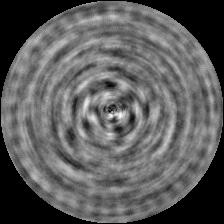

 Expected RMS:   20.000,   30.000
Predicted RMS:   27.032,   35.833
 Error at std:  +-5.559,  +-1.225


In [78]:
# Load image and define parameters
test_img = cv2.imread("/content/map_fit/8bit/-137.319_158.003_37.932_20_30.jpg",-1)
Z = [-137.319,158.003]
RMS = 37.932
E_RMS = [20,30]

# Show test image
cv2_imshow(test_img)

# Normalize image
X = np.array(test_img).astype(np.float32)
X = (X/255)*(Z[1]-Z[0])+Z[0]
X = X/RMS

# Define target distribution
mean = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)
std = torch.tensor([0.5, 0.5, 0.5]).view(3,1,1)

# Define corrected distribution for masked image
fact = torch.div(SIZE**2,idx_t.sum(dim=[1,2])).view(3,1,1)
corr_mean = torch.mul(fact,mean)
corr_std = torch.sqrt(torch.mul(fact,torch.pow(std,2)) - torch.mul(torch.mul(fact,fact-1),torch.pow(mean,2)))

# Define transformations
lambdaMask = lambda T: torch.mul(T,idx_t)
lambdaNorm = lambda T: torch.div(T-T.mean(dim=[1,2]).view(3,1,1),T.std(dim=[1,2]).view(3,1,1))
lambdaScale = lambda T: torch.mul(T,corr_std) + corr_mean

# Compute transformed image
X = transforms.Compose([
            transforms.ToPILImage(),
            #transforms.Grayscale(num_output_channels=3),
            transforms.ToTensor(),
            transforms.Lambda(lambdaMask),
            transforms.Lambda(lambdaNorm),
            transforms.Lambda(lambdaScale),
            transforms.Lambda(lambdaMask),
            ])(X)

# Add dummy batch dimension
X = X[None,:,:,:]

# Compute prediction
model.eval()
with torch.no_grad():
    y = model(X)

# Print results
print(f' Expected RMS:   {E_RMS[0]:.3f},   {E_RMS[1]:.3f}')
print(f'Predicted RMS:   {RMS*y[0,0].item():.3f},   {RMS*y[0,1].item():.3f}')
print(f' Error at std:  +-{std_rdb*RMS:.3f},  +-{std_mfcirc*RMS:.3f}')

Errors on the following block are mostly fixed by restarting it

In [69]:
# Target filename
filename = f'/content/{model_name}_{std_rdb:.3f}_{std_mfcirc:.3f}_inf.onnx' # drive/MyDrive/ 

# Example input
x = torch.randn(1, 3, SIZE, SIZE, requires_grad=True)

# Export the model to Open Neural Network eXchange (ONNX)
model.to_onnx(filename, x, export_params=True)